[View in Colaboratory](https://colab.research.google.com/github/iampatgrady/Demand-Forecasting-for-NYC-Taxi-Cabs-Using-BigQuery-and-TensorFlow/blob/master/demandforecast.ipynb)

port of GCP Codelab Notebook to Colaboratory: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4a/demandforecast.ipynb
# Demand Forecasting for Taxi cabs in NYC using Weather Data


In this notebook, we will develop a machine learning model to predict the demand for taxi cabs in New York.

To develop the model, we will need to get historical data of taxicab usage. This data exists in BigQuery. Let's start by looking at the schema.

In [0]:
import pandas as pd
import numpy as np
import shutil
import io
import matplotlib.pyplot as plt
import seaborn as sns

## Analyzing taxicab demand 

###BigQuery to Pandas dataframe 

Use the total number of trips as proxy for taxicab demand

In [0]:
config = {
	'query': {
		'parameterMode': "NAMED",
		'queryParameters': [{
			'name': 'YEAR',
			'parameterType': {
				'type': 'STRING'
			},
			'parameterValue': {
				'value': 2015
			}
		}]
	}
}

In [3]:
query = """
WITH trips AS (
  SELECT EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber 
  FROM `bigquery-public-data.new_york.tlc_yellow_trips_*`
  where _TABLE_SUFFIX = @YEAR
)
SELECT daynumber, COUNT(1) AS numtrips FROM trips
GROUP BY daynumber ORDER BY daynumber
"""

trips = pd.io.gbq.read_gbq(query,project_id='analyticspros.com:spotted-cinnamon-834',
     dialect='standard', verbose=False, configuration = config )

trips.sample(5)

,daynumber,numtrips
136,137,423198
352,353,460986
293,294,389756
307,308,384089
0,1,382014


##Weather data


### Variables

Minimum, maximum daily temperature (in Fahrenheit), and amount of rain (in inches) for La Guardia airport.

In [4]:
wxquery = """
SELECT EXTRACT (DAYOFYEAR FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber,
       MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE stn='725030' AND _TABLE_SUFFIX = @YEAR
GROUP BY 1 ORDER BY daynumber ASC
"""

weather =  pd.io.gbq.read_gbq(wxquery,project_id='analyticspros.com:spotted-cinnamon-834',
     dialect='standard', verbose=False, configuration = config)

weather.sample(5)

,daynumber,dayofweek,mintemp,maxtemp,rain
199,200,1,72.0,93.9,0.18
298,299,2,48.0,68.0,0.02
114,115,7,39.0,60.1,0.00
205,206,7,71.1,84.9,0.00
325,326,1,43.0,55.9,0.00


### Merge datasets 

Use Pandas to combine weather and taxi data

In [5]:
dataframe = pd.merge(weather, trips, on='daynumber')
dataframe[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,1,5,27.0,39.0,0.00,382014
1,2,6,27.0,42.1,0.00,345296
2,3,7,30.9,42.1,0.00,406769
3,4,1,30.9,57.0,0.85,328848
4,5,2,28.9,57.0,0.13,363454


### Exploratory analysis

Is there a relationship between maximum temperature and the number of trips?

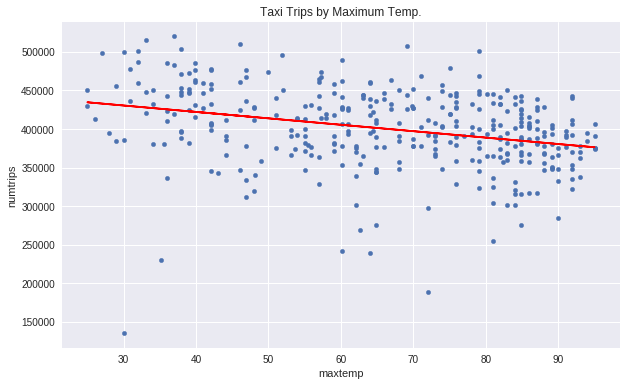

In [6]:
x = dataframe.maxtemp
y = dataframe.numtrips
dataframe.plot(kind="scatter",x="maxtemp",y="numtrips", figsize=[10,6])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.title("Taxi Trips by Maximum Temp.")
plt.show()

There appears to be a weak downward trend, but it's also quite noisy.

Is there a relationship between the day of the week and the number of trips?

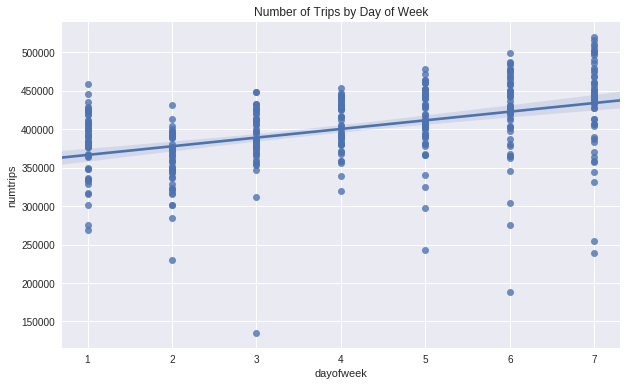

In [7]:
fig, ax = plt.subplots(figsize=[10,6])
sns.regplot(dataframe.dayofweek,y)
plt.title("Number of Trips by Day of Week")
plt.show()

It appears that people use taxis more later in the week. 

Remove <em>confounding</em> effect of the day of the week:

In [0]:
df = dataframe[dataframe['dayofweek']== 7] # analyze only Sunday riders

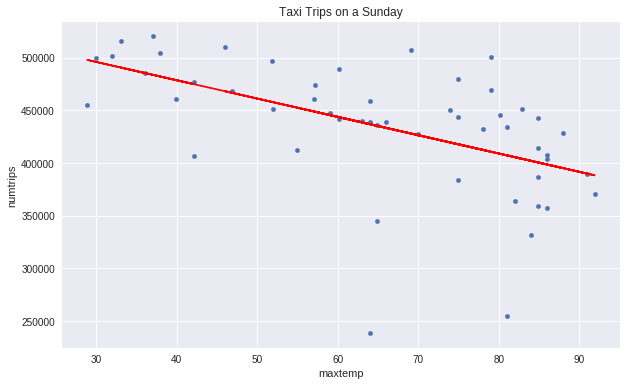

In [9]:
x = df.maxtemp
y = df.numtrips
df.plot(kind="scatter",x="maxtemp",y="numtrips",figsize=[10,6])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.title("Taxi Trips on a Sunday")
plt.show()

### Adding 2014 and 2016 data
Let's add in 2014 and 2016 data to the Pandas dataframe. 

In [10]:
data2 = dataframe # 2015 data

for year in [2014,2016]:
  
  config["query"]["queryParameters"][0]["parameterValue"]["value"] = year

  weather = pd.io.gbq.read_gbq(wxquery,project_id='analyticspros.com:spotted-cinnamon-834',
      dialect='standard',  verbose=False, configuration = config)

  trips = pd.io.gbq.read_gbq(query,project_id='analyticspros.com:spotted-cinnamon-834',
      dialect='standard', verbose=False, configuration = config )

  data_for_year = pd.merge(weather, trips, on='daynumber')
  data2 = pd.concat([data2, data_for_year])
    
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,183.166971,4.005474,48.195073,66.151825,0.117272,403642.694343
std,105.510927,2.000449,18.031228,18.484065,0.320836,63767.524397
min,1.000000,1.000000,1.000000,21.000000,0.000000,78133.000000
25%,92.000000,2.000000,35.100000,51.950000,0.000000,363809.000000
50%,183.000000,4.000000,48.900000,68.000000,0.000000,402184.500000
75%,274.250000,6.000000,64.400000,82.900000,0.050000,447099.000000
max,366.000000,7.000000,82.000000,99.000000,4.880000,574530.000000


In [0]:
df = data2[data2['dayofweek']== 7]

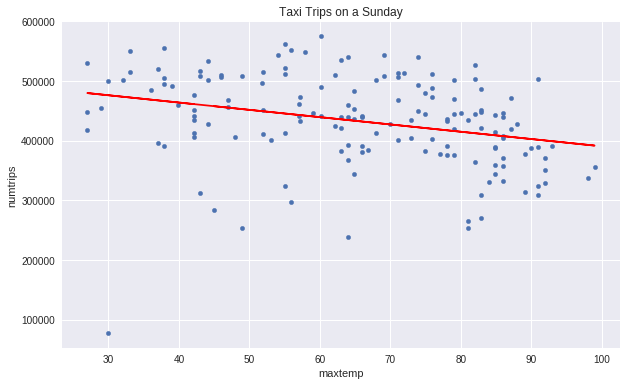

In [12]:
x = df.maxtemp
y = df.numtrips
df.plot(kind="scatter",x="maxtemp",y="numtrips",figsize=[10,6])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.title("Taxi Trips on a Sunday")
plt.show()

## Machine Learning with Tensorflow 

We'll use 80% of our dataset for training and 20% of the data for testing the model we have trained. 

In [0]:
import tensorflow as tf
import logging
#keep output clean
logging.getLogger('tensorflow').disabled = True


In [14]:
# TODO: Add a Scaler to the data, could improve NN performance
"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normal_data = scaler.fit_transform(data2.sample(frac=1, random_state=13))"""

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nnormal_data = scaler.fit_transform(data2.sample(frac=1, random_state=13))'

In [0]:
shuffled = data2.sample(frac=1, random_state=13)
predictors = shuffled.iloc[:,1:5] 
targets = shuffled.iloc[:,5]

### Establish Benchmark 

Let's create our benchmark based on the 80-20 split and the larger dataset.

In [16]:
trainsize = int(len(shuffled) * 0.8)  #80% of total
avg = np.mean(shuffled['numtrips'][:trainsize]) 
rmse = np.sqrt(np.mean((shuffled['numtrips'][trainsize:] - avg)**2))
print 'Average={0} has RMSE of {1}'.format(avg, rmse)

Average=402208.888128 has RMSE of 62814.068818


RMSE - root-mean-square error

If you guess 400K rides for a day, odds are, you'll be within ~62,000 of the actual number.

## Linear regression with tf.contrib.learn.LinearRegressor 

We scale the number of taxicab rides by targets.max() so that the model can keep its predicted values in the [0-1] range.

In [17]:
SCALE_NUM_TRIPS = float(targets.max())
trainsize = int(len(shuffled) * 0.8)
testsize = len(shuffled) - trainsize
npredictors = len(predictors.columns)
noutputs = 1

shutil.rmtree('./trained_model_linear', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ..."
def input_fn(features, targets):
    return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean(np.power((targets[trainsize:] - pred), 2)))
print 'LinearRegression has RMSE of {0}'.format(rmse)


starting to train ... this will take a while ...
LinearRegression has RMSE of 56191.5992856


The RMSE here (56K) is lower than the benchmark (62K) indicates that we are doing about 10% better with the machine learning model than we would be if we were to just use the historical average (our benchmark).

## Neural network with tf.contrib.learn.DNNRegressor 

Let's make a more complex model with two hidden nodes.

In [18]:
SCALE_NUM_TRIPS = float(targets.max())
trainsize = int(len(shuffled) * 0.8)
testsize = len(shuffled) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
layers = [5]

shutil.rmtree('./trained_model', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.DNNRegressor(model_dir='./trained_model',
                                          hidden_units=layers,
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ..."
def input_fn(features, targets):
    return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=30000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean((targets[trainsize:].values - pred)**2))
print 'Neural Network Regression has RMSE of {0}'.format(rmse)

starting to train ... this will take a while ...
Neural Network Regression has RMSE of 56618.066338


Using a neural network results in similar performance to the linear model in this example

## Running a trained model 

So, we have trained a model, and saved it to a file. Let's use this model to predict taxicab demand given the expected weather for three days.

Here we make a Dataframe out of those inputs, load up the saved model and use it to predict the taxicab demand.

In [0]:
input = pd.DataFrame.from_dict(data = 
                               {'dayofweek' : [4, 5, 6],
                                'mintemp' : [60, 60, 60],
                                'maxtemp' : [70, 70, 70],
                                'rain' : [0, 0, 0]})

In [20]:
lr_estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))


nn_estimator = tf.contrib.learn.DNNRegressor(model_dir='./trained_model',
                                          hidden_units=layers,                             
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))

lr_pred = np.multiply(list(lr_estimator.predict(input.values)), SCALE_NUM_TRIPS )

nn_pred = np.multiply(list(nn_estimator.predict(input.values)), SCALE_NUM_TRIPS )
print "Linear Regression: {}\nNeural Network: {}".format(lr_pred,nn_pred)

Linear Regression: [351743.97 363407.66 375071.38]
Neural Network: [-2706733.8 -2716456.8 -2726181.5]


`Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License`